<a href="https://colab.research.google.com/github/StevenXDiaz/AstroPersonalWebsite/blob/main/Copy_of_MS%26E233_HW7_Spring2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MS&E 233 (Spring 2025): Homework 7 (due June 1st, 8pm)

# Problem 1. ERM over Personalized Reserve Prices

In this problem we'll be exploring the revenue of running ERM over personalized reserve prices and using the Second-Price Auction with personalized reserves.

We will consider a setting with two bidders. Bidder 1 has values distributed as $v_1\sim U[0, A]$ and bidder 2 has values distributed as $v_2\sim U[0, B]$.






In [14]:
import numpy as np
np.random.seed(123)
A = 1.0
B = 2.0
def gen_data(n_samples, A=A, B=B):
    v1 = np.random.uniform(0, A, size=n_samples)
    v2 = np.random.uniform(0, B, size=n_samples)
    return v1, v2

## 1.1 Let's First Re-Implement the Myerson Auction and Calculate a very Accurate Estimate of the Optimal Revenue and Also Re-Implement Second-Price with Personalized Reserves

We implement the Myerson auction. You already solved this in your previous homework for the case of A=15 and B=20. Generalize it to any A, B. If you solved it using a for loop then try to re-implement it avoiding any "for" loops which are painfully slow in python.

**Hint:** For instance, as a simplistic example if the rules say that we collect revenue `v2` whenever `v1 >= v2`, and we collect revenue `v1` when `v1 < v2`, then if `v1` and `v2` are vectors that contain samples of values of bidder 1 and bidder 2, then we can calculate the revenue for each auction profile as:
```python
rev = 1.0 * (v1 >= v2) * v2 + 1.0 * (v1 < v2) * v1
avg_rev = np.mean(rev)
```
which does not use any for loop over the auction samples.

In [23]:
def simulate_myerson(v1, v2, A=A, B=B):
    '''(1 points)
    v1: samples for bidder 1
    v2: samples for bidder 2
    '''
    assert len(v1) == len(v2)

    # Calculate revenue for each of the sampled value profiles
    # We avoid any for loop, which is painfully slow.
    phi_1 = 2*v1-A
    phi_2 = 2*v2-B

    passes = (phi_1 >= 0) | (phi_2 >= 0)

    firstBidWins = (phi_1 >= phi_2) & passes
    secondBidWins = (phi_1 < phi_2) & passes

    first = np.where(phi_2 <= 0, 0.5 * A, 0.5 * (phi_2 + A))
    second = np.where(phi_1 <= 0, 0.5 * B, 0.5 * (phi_1 + B))

    rev = np.zeros_like(v1)
    rev[firstBidWins] = first[firstBidWins]
    rev[secondBidWins] = second[secondBidWins]

    # we then return the average revenue
    return np.mean(rev)

In [24]:
# Let's calculate a very accurate approximation of the optimal revenue
# by drawing a very large number of samples and calculating the empirical
# average of Myerson's revenue
np.random.seed(123)
v1, v2 = gen_data(100000)
rev = simulate_myerson(v1, v2)
print(f'Optimal Revenue={rev:.3f}')

Optimal Revenue=0.647


**Expected Answers** You should be getting
```
Optimal Revenue=0.647
```

**Secon Price with Personalized Reserves (SPA-r) Auction** Implement the Second Price Auction with Player-Specific Reserves, described in Slide 49 of [Lecture 12](https://raw.githubusercontent.com/stanford-msande233/spring24/master/assets/presentations/Lecture12.pdf).

In particular
1. Each bidder $i$ has a reserve price $r_i$
2. Reject all bidders with bid below the reserve
3. Among all bidders with value $v_i \geq r_i$ allocate to highest bidder
4. Charge winner max of their reserve and the next highest non-rejected bid

We will implement this auction only for the special case of two bidders and arbitrary reserve prices $r_1, r_2$.

This exercise was also asked of you in the last homework. Copy your code. If you were using a for loop, re-implement it without a for loop, as you did for the Myerson auction.


In [25]:
def simulate_non_identical_spa_with_reserves(v1, v2, r1, r2):
    '''(1 points)
    v1: samples for bidder 1
    v2: samples for bidder 2
    r1: reserve price for bidder 1
    r2: reserve price for bidder 2
    '''
    assert len(v1) == len(v2)

    # We again avoid any for loop
    firstBidPasses = (v1 >= r1)
    secondBidPasses = (v2 >= r2)

    bothPass = firstBidPasses & secondBidPasses
    firstBidWins = bothPass & (v1 > v2)
    secondBidWins = bothPass & (v1 <= v2)

    rev = np.zeros_like(v1)
    rev[firstBidWins] = np.maximum(v2[firstBidWins], r1)
    rev[secondBidWins] = np.maximum(v1[secondBidWins], r2)

    rev[firstBidPasses & ~bothPass] = r1
    rev[secondBidPasses & ~bothPass] = r2


    # we then return the average revenue
    return np.mean(rev)

## Problem 1.2 Optimize over the Personalized Reserves

Now let's implement ERM over the reserves. Remember that wlog it suffices to search over the $2*m$ samples values from the bidders. Any other reserve price will be sub-optimal.

In [26]:
np.random.seed(123)

def erm_spa_personalized_reserves(v1, v2):
    #(0.5 points)
    best_rev = 0
    best_r1 = 0
    best_r2 = 0
    # Calculate the candidate reserve prices for each bidder as the union
    # of all the unique values of any bidder among the samples.
    # So if bidder 1 had samples V1={v11, ..., v1m}
    # and bidder 2 had samples V2={v21, ..., v24} we will consider the unique
    # values in the union of these two sets as plausible reserves for each bidder
    candidates = np.unique(np.concatenate((v1, v2)))
    # Go over candidate pairs of reserve prices (r1, r2) for each bidder
    for r1 in candidates:
        for r2 in candidates:
            # calculate revenue of SPA-r auction on the samples v1, v2
            rev = simulate_non_identical_spa_with_reserves(v1, v2, r1, r2)
            # if better than current best then update
            if rev > best_rev:
                best_r1, best_r2, best_rev = r1, r2, rev
    return best_r1, best_r2, best_rev

In [27]:
# Suppose we have 100 historical samples. Run ERM and report the
# reserve prices calculated as well as the revenue on the historical samples
# i.e. the revenue on the "training set"
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = erm_spa_personalized_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev_train={best_rev:.3f}')

# Now we examine how these reserves perform next year.
# Suppose next year we run 10000 iterations of the same auction
# what average revenue do we get
v1test, v2test = gen_data(10000)
rev_test = simulate_non_identical_spa_with_reserves(v1test, v2test, best_r1, best_r2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev_test={rev_test:.3f}')

r1=0.532, r2=1.096, rev_train=0.708
r1=0.532, r2=1.096, rev_test=0.635


**Expected Answers** You should be getting
```
r1=0.532, r2=1.096, rev_train=0.708
r1=0.532, r2=1.096, rev_test=0.635
```

Discuss the difference in training revenue and test revenue. Does it align with what we learned in class? (0.5 points)

# **[Place your answer here]**

Our test revenue is smaller than our training revenue since the reserves lead to a bit of overtraining. This does align with what we learned in class.

## Problem 1.3 Implement a Parallel Version of the ERM

We can improve run time by implementing a parallel version of the search over reserve prices. We will use the `Parallel, delayed` functions from `joblib`. See
https://joblib.readthedocs.io/en/latest/parallel.html
for more details on how to use them.

If you have a function `func` with arguments `args` and which returns a scalar `out`, then you can run the function in parallel with different arguments, by simply writing:
```python
outs = Parallel(n_jobs=-1, verbose=3)(delayed(func)(args_it) for args_it in args_list)
```
Now `outs` is a list of all the `out` for each call of func, with the corresponding arguments `args_it`.


In [40]:
import joblib
import joblib
from itertools import product

def parallel_erm_spa_personalized_reserves(v1, v2, grid=False, A=A, B=B):
    #(1 points)
    if grid:
        # For the case when v1, v2 have too many samples, it might be too
        # expensive to go over (2m)**2 possibilities for (r1, r2). We will
        # get a very similar accuracy if we simply search over a fine enough
        # grid
        reserves = list(product(np.linspace(0, A, 100), np.linspace(0, B, 100)))
    else:
        # For the case when v1, v2 don't have that many samples, we use the
        # same candidates as in the previous question
        candidates = np.unique(np.concatenate((v1, v2)))
        # Define the set of plausible pairs of reserves (r1, r2) into a list
        # Hint: see how we did it above for the grids
        reserves = list(product(candidates, repeat=2))

    # Run a parallel for loop over the plausible pairs of reserve prices (r1, r2)
    # to construct a list of all the revenues that correspond to each pair
    revs = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(simulate_non_identical_spa_with_reserves)(v1, v2, r1, r2)
        for r1, r2 in reserves
    )
    # find the best revenue pair (don't use a for loop)
    best_rev = revs[np.argmax(revs)]
    # find the reserve prices that correspond to the best revenue pair
    # (don't use a for loop)
    best_r1, best_r2 = reserves[np.argmax(revs)]
    # return the best reserves and best revenue
    return best_r1, best_r2, best_rev

In [41]:
# Suppose we have 100 historical samples. Run ERM and report the
# reserve prices calculated as well as the revenue on the historical samples
# i.e. the revenue on the "training set"
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = parallel_erm_spa_personalized_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev_train={best_rev:.3f}')

# Now we examine how these reserves perform next year.
# Suppose next year we run 10000 iterations of the same auction
# what average revenue do we get
v1test, v2test = gen_data(10000)
rev_test = simulate_non_identical_spa_with_reserves(v1test, v2test, best_r1, best_r2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev_test={rev_test:.3f}')

r1=0.532, r2=1.096, rev_train=0.708
r1=0.532, r2=1.096, rev_test=0.635


**Expected Answer**
```
r1=0.532, r2=1.096, rev_train=0.708
r1=0.532, r2=1.096, rev_test=0.635
```

In [42]:
# Let's calculate the optimal reserve prices by using a very large number of
# historical samples and searching over a grid of prices, instead of all the
# (2*m)**2 possible pairs of reserves
np.random.seed(1234)
v1pop, v2pop = gen_data(100000)
opt_r1, opt_r2, opt_rev = parallel_erm_spa_personalized_reserves(v1pop, v2pop, grid=True)

In [43]:
print(f'r1={opt_r1:.3f}, r2={opt_r2:.3f}, opt_rev_population={opt_rev:.3f}')
# also calculate the revenue that the ERM reserves we estimated area achieving
rev_pop = simulate_non_identical_spa_with_reserves(v1pop, v2pop, best_r1, best_r2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev_population={rev_pop:.3f}')

r1=0.495, r2=1.111, opt_rev_population=0.632
r1=0.532, r2=1.096, rev_population=0.631


**Expected Answer**
```
r1=0.495, r2=1.111, opt_rev_population=0.632
r1=0.532, r2=1.096, rev_population=0.631
```

How close was the revenue of the reserve prices we found to the revenue of the optimal reserves? (0.5 points)


# **[Place your answer here]**

The revenues are almost identical so the ERM process is a good process.

# Problem 2. Second Price Auction with Lazy Reserve Prices

Optimizing over reserve prices in the SPA-r auction requires going over a grid of prices for each bidder. This leads to an exponential explosion of the search space for each bidder, i.e. we need to search over $(n m)^n$ tuples of reserve prices!

Even for $n=2$ the previous exercise showcases, that things can get slow quite quickly.

It would have been nicer if instead we had an algorithm to optimize over reserve prices that only scales linearly with the number of bidders. For instance, maybe we only need to optimize reserve prices separately for each bidder and not jointly across bidders. Then we would only need to perform $O(nm)$ operations per bidder, which would still only be $O(n^2 m)$ operations. This can make a big difference in practice, with a lot of historical samples and several bidders. Even with two bidders, this will be a big time saver.

Unfortunately, optimizing the reserves in SPA-r is an NP-hard problem (see. https://arxiv.org/abs/1602.07720) We will now consider an alternative variant of the SPA auction, which as proven in https://arxiv.org/abs/1602.07720 allows for the optimization of reserve prices in near linear time in the number of bidders!

This is called the Lazy-Reserves SPA. You can read Section 3 of the paper for more details. But here are the essentials. In the lazy reserves, we always only consider allocating to the highest bidder. We never discard bids. So we only look at the highest bidder $b_(1)$. If that bidder passes their personalized reserve $r_(1)$, then we allocate to them and we charge them the maximum of the second highest bid or their personalized reserve $\max\{b_{(2)}, r_{(1)}\}$. If the highest bidder does not pass the reserve, then we discard the item and don't allocate to anyone. So the rules are:
1. If $b_{(1)} < r_{(1)}$, then discard the item and don't allocate to anyone and get zero revenue
2. If $b_{(1)} \geq r_{(1)}$, then allocate to the highest bidder and charge them $\max\{b_{(2)}, r_{(1)}\}$.

More concretely, if we have two bidders, then we can see that these rules say that:
1. If $v_1 >= v_2$ and $v_1 \geq r_1$, then allocate to bidder 1 and charge $\max\{b_2, r_1\}$.
2. If $v_2 > v_1$ and $v_2 \geq r_2$, then allocate to bidder 2 and charge $\max\{b_1, r_2\}$.
3. Otherwise don't allocate to anyone and get zero revenue.

## Problem 2.1. Implement Lazy Reserves

Implement the Lazy reserves second price auction. When taking a set of samples of value profiles for the bidders, calculate the revenue of the Lazy Reserves SPA, for each auction sample and then average the revenue

In [44]:
def simulate_non_identical_spa_with_lazy_reserves(v1, v2, r1, r2):
    '''(0.5 points)
    v1: samples for bidder 1
    v2: samples for bidder 2
    r1: reserve price for bidder 1
    r2: reserve price for bidder 2
    '''
    assert len(v1) == len(v2)
    # Calculate the revenue of the lazy reserves SPA-r for each samples
    # We again avoid any for loop
    rev = np.zeros_like(v1)

    firstBidWins = (v1 > v2) & (v1 >= r1)
    rev[firstBidWins] = np.maximum(v2[firstBidWins], r1)

    secondBidWins = (v2 > v1) & (v2 >= r2)
    rev[secondBidWins] = np.maximum(v1[secondBidWins], r2)


    # Return the average revenue
    return np.mean(rev)

In [45]:
# Let's compare if lazy vs eager makes any difference
# for a natural choice of reserves
np.random.seed(123)
v1, v2 = gen_data(100000)
rev = simulate_non_identical_spa_with_reserves(v1, v2, A/2, B/2)
print(f'Revenue={rev:.3f}')
rev = simulate_non_identical_spa_with_lazy_reserves(v1, v2, A/2, B/2)
print(f'Revenue={rev:.3f}')

Revenue=0.625
Revenue=0.605


**Expected Answer**
```
Revenue=0.625
Revenue=0.605
```

## Problem 2.2. Implement Parallelized ERM over Lazy Reserves

As a first step, let's implement the exact same parallelized ERM as what we did for the eager reserves, without any of the efficiency gains described in the paper. This is the analogue of what you did for Eager reserves in the previous problem.

In [52]:
from joblib import Parallel, delayed
from itertools import product

np.random.seed(123)

def erm_spa_personalized_lazy_reserves(v1, v2, grid=False, A=A, B=B):
    #(1 points)
    if grid:
        reserves = list(product(np.linspace(0, A, 100), np.linspace(0, B, 100)))
    else:
        # For the case when v1, v2 don't have that many samples, we use the
        # same candidates as in the previous question
        candidates = np.unique(np.concatenate([v1, v2]))
        # Define the set of plausible pairs of reserves (r1, r2) into a list
        # Hint: see how we did it above for the grids
        reserves = list(product(candidates, candidates))
    # Run a parallel for loop over the plausible pairs of reserve prices (r1, r2)
    # to construct a list of all the revenues that correspond to each pair
    revs = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(simulate_non_identical_spa_with_lazy_reserves)(v1, v2, r1, r2)
        for r1, r2 in reserves)
    # find the best revenue pair (don't use a for loop)
    best_rev = revs[np.argmax(revs)]
    # find the reserve prices that correspond to the best revenue pair
    # (don't use a for loop)
    best_r1, best_r2 = reserves[np.argmax(revs)]
    # return the best reserves and best revenue
    return best_r1, best_r2, best_rev

Let's calculate the ERM over lazy reserves with 100 historical samples.

In [53]:
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = erm_spa_personalized_lazy_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.532, r2=1.096, rev=0.674


**Expected Answer**
```
r1=0.532, r2=1.096, rev=0.674
```

Let's compare with the ERM over eager reserves

In [54]:
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = parallel_erm_spa_personalized_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.532, r2=1.096, rev=0.708


**Expected Answer**
```
r1=0.532, r2=1.096, rev=0.708
```

Which of the two revenues is larger? Which of the Theorems in Section 4.2 of the paper is relevant to our setting? When optimizing over lazy reserves, should we expect to get smaller or larger revenue than when optimizing over eager reserves, in the setting that we consider here? (1 points)

# **[Place your answer here]**

The eager reserves method gave us a larger revenue than the lazy reserves did, and this aligns with Theorem 7 of the provided paper, since our bidder valuations are drawn independently.

## Problem 2.3 Implement Efficient ERM over Lazy Reserves

By the rules of the lazy reserve auction, we can write the revenue of the auction on the samples as:
\begin{align}
\sum_{j=1}^m \left(1\{v_1^j \geq v_2^j\}\cdot 1\{v_1^j \geq r_1\}\cdot \max\{v_2, r_1\} + 1\{v_1^j < v_2^j\}\cdot 1\{v_2^j \geq r_2\}\cdot \max\{v_1^j, r_2\}\right)
\end{align}
Note that this objective decomposes into two components and the first component only depends on $r_1$, while the second component only depends on $r_2$! This is the key difference between lazy and eager reserves. With eager reserves, there objective doesn't decompose into these separate components. This separation also holds when we have many bidders! (see Section 5 of the paper https://arxiv.org/pdf/1602.07720)

Thus we don't really need to jointly optimize the two components over pairs of $(r_1, r_2)$, it suffices that we separately optimize each compoment!
\begin{align}
\max_{r_1}  \text{Rev}_1(r_1) \triangleq \sum_{j: v_1^j \geq v_2^j} \max\{v_2^j, r_1\}\cdot  1\{v_1^j \geq r_1\}\\
\max_{r_2} \text{Rev}_2(r_2) \triangleq \sum_{j: v_2^j > v_1^j} \max\{v_1^j, r_2\} \cdot 1\{v_2^j \geq r_2\}
\end{align}
The first objective optimizes over samples where bidder 1 is the highest bidder and the second objective optimizes over samples where bidder 2 is the highest bidder.

For each objective, it suffices to consider only the $2\cdot m$ sets of reserve prices that appear in the objective. Any other reserve price is sub-optimal. Thus if we let $J_1=\{j: v_1^j \geq v_2^j\}$ be the set of auctions where bidder 1 is the highest value bidder and $J_2=\{j: v_2^j > v_1^j\}$, the set of auctions where bidder 2 is the highest value bidder, then for the first optimization, we only need to optimize over reserves
$$R_1 = \cup_{j\in J_1} \{v_1^j, v_2^j\}$$
and for the second optimization we only need to optimize over reserves $$R_2=\cup_{j\in J_2}\{v_1^j, v_2^j\}.$$

We can solve the first optimization problem, by simply going over all candidate reserve prices $r_1\in R_1$ and calculating the revenue. There are $O(2|J_1|)$ such candidate reserve prices and calculating the revenue for each candidate takes time $O(|J_1|)$. Thus all in all, we need $O(|J_1|^2)$. Similarly for the second problem. Thus all in all we need $O((2m)^2)$. With $n$ bidders, this would remain $O((nm)^2)$ and not $O((nm)^n)$. In Python we should see a faster run time, simply because calculating the revenue for each candidate reserve is very fast. If we were to take that runtime into account in our previous implementation, then we would be getting that the eager algorithm needed $O((2m)^3)$ calculations. Hence, we saved an order of magnitude (especially for large $m$).

Let's implement this!


In [57]:
np.random.seed(123)

def better_erm_spa_personalized_lazy_reserves(v1, v2):
    #(1 points)
    best_rev1 = -1
    best_r1 = 0
    # Calculate the set of candidate reserve prices R_1
    # We first find the subset of auctions where v_1>=v2
    winner1 = v1>v2
    # Then we take the union of the unique values of \cup_j \{v_1^j, v_2^j\}
    # in this set
    candidates = np.unique(np.concatenate((v1[winner1], v2[winner1])))
    # Now we go over all these candidate reserves for bidder 1
    for r1 in candidates:
        # we calculate the total revenue on the subset of samples
        # for which bidder 1 is the highest bidder, i.e. the quantity Rev1(r1)
        rev1 = np.sum(np.maximum(v2[winner1], r1) * (v1[winner1] >= r1))
        # if it is larger than the current best, we update
        if rev1 > best_rev1:
            best_r1, best_rev1 = r1, rev1

    best_rev2 = -1
    best_r2 = 0
    # Calculate the set of candidate reserve prices R_2
    # We first find the subset of auctions where v_2 > v1
    winner2 = v2>v1
    # Then we take the union of the unique values of \cup_j \{v_1^j, v_2^j\}
    # in this set
    candidates = np.unique(np.concatenate((v1[winner2], v2[winner2])))
    # Now we go over all these candidate reserves for bidder 2
    for r2 in candidates:
        # we calculate the total revenue on the subset of samples
        # for which bidder 2 is the highest bidder, i.e. the quantity Rev2(r2)
        rev2 = np.sum(np.maximum(v1[winner2], r2) * (v2[winner2] >= r2))
        # if it is larger than the current best, we update
        if rev2 > best_rev2:
            best_r2, best_rev2 = r2, rev2

    # we return the best reserve for r1 and for r2
    # we also return the average revenue of these two reserves. Note that
    # this should be (Rev1(r1) + Rev2(r2)) / total_number_of_samples
    return best_r1, best_r2, (best_rev1 + best_rev2) / len(v1)

Let's measure the time it takes to run ERM over 100 historical samples. We can easily do that with the `%%time` magic command

In [60]:
%%time
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = better_erm_spa_personalized_lazy_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.532, r2=1.096, rev=0.674
CPU times: user 2.39 ms, sys: 35 µs, total: 2.42 ms
Wall time: 2.4 ms


**Expected Answer**
```
r1=0.532, r2=1.096, rev=0.674
```

Let's compare the result and the compute time with the non-efficient implementaiton we did  in the previous sub-problem. We should be getting the exact same answer as the one we got with the slower code above, that doesn't use this decomposition observation.


In [61]:
%%time
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = erm_spa_personalized_lazy_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.532, r2=1.096, rev=0.674
CPU times: user 458 ms, sys: 4.35 ms, total: 463 ms
Wall time: 1.15 s


Comment on the run time of the two versions! (0.25 points)

The first version was almost instant, but the next version took about a second, so the first verdsion is faster.

# **[Place your answer here]**

## Problem 2.4 Implement Even more Efficient ERM over Lazy Reserves

The paper https://arxiv.org/pdf/1602.07720 proposes an even more efficient approach that can calculate the optimal reserve for each bidder in almost linear time $O(|J_i|)$, instead of $O(|J_i|^2)$ (see Proposition 10).

In particular, note that if we sort the candidate reserve prices in $R_1$ in increasing order, then, if we have already calculate the revenue for the $t$-th reserve price in this order, then we can easily calculate the revenue for the $t+1$-th reserve price, without the need to go over all the samples again!

To do this, we need to also store, whether the $t$-th reserve price corresponds to a bid of bidder 1 or a bid of bidder 2. Note that the revenue of a reserve price $r_1$ can be written as:
\begin{align}
\text{Rev}_1(r_1) = r_1 \cdot k(r_1) + s(r_1)
\end{align}
where $k(r_1)$ is the number of samples $j\in J_1$, for which $v_2^j < r_1$, i.e. for which the reserve of bidder 1 is the binding price and not the second highest bid and at the same time $v_1 \geq r_1$, so that we allocate the item and collect the price. Then $s(r_1)$ is the revenue from the remaining samples where $v_2^j$ is the binding price (in which case note that we definitely allocate the item since $v_1^j \geq v_2^j \geq r_1$), i.e.
\begin{align}
s(r_1) = \sum_{j\in J_1} v_2^j \cdot 1\{v_2^j \geq r_1\}
\end{align}

Let's order the reserve prices in the candidate set in increasing order $\{r_1, \ldots, r_{2|J_1|}\}$. Suppose that we have calculated $k(r_t)$ and $s(r_t)$ for the $t$-th price in this order. Now we consider moving to the next reserve price $t+1$ and hence moving past the reserve price $r_t$.
1. If $r_{t}$ corresponds to a value of bidder 2, then by moving past this reserve, we make the reserve price binding for one more sample in $J_1$, thus $k(r_{t+1})=k(r_t)+1$ and we remove this entry from the summand in $s$, i.e. $s(r_{t+1})=s(r_t)-r_t$.  
2. If $r_t$ corresponds to a value of bidder 1, then by moving past this reserve, we stop allocating the item in one of the samples, i.e. $k(r_{t+1})=k(r_t)-1$, but we don't change at all the payment collected from samples were the second highest bid is the binding price, i.e. $s(r_{t+1})=s(r_t)$.

In the begining, when we consider the lowest reserve price in $R_1$, then all the samples are allocated and the second highest bid is the binding price for all of them, hence $k(r_1)=0$ and $s(r_1)=\sum_{j\in J_1} v_2^j$.

Let's implement this!

In [69]:
np.random.seed(123)

def even_better_erm_spa_personalized_lazy_reserves(v1, v2):
    #(1.5 points)

    # Indicator of which auctions bidder 1 is the winner
    winner1 = v1>v2
    # Total number of auctions for which bidder 1 is the winner
    n1 = np.sum(winner1)
    # Candidate reserve prices R_1. Watch out here not to take only
    # the unique elements, as we need to keep track of the type of each element.
    # It's ok to have a multiset
    candidates = np.concatenate((v1[winner1], v2[winner1]))
    # Type of each candidate reserve, i.e. was it a bidder 1 value or a bidder 2?
    types = np.concatenate(((np.ones(n1), np.zeros(n1))))
    vals = np.concatenate([np.zeros(n1), v2[winner1]])
    # Sort the reserves in increasing order and make sure you re-order
    # the types so that they accompany the newly sorted reserves
    candidates = candidates[np.argsort(candidates)]
    types = types[np.argsort(candidates)]
    vals = vals[np.argsort(candidates)]

    # Let's implement the recursive algorithm for r1
    best_rev1 = -1
    best_r1 = 0
    # we initialize the quanity k=k(r1) and s=s(r1)
    k = 0
    s = np.sum(v2[winner1])
    # for each candidate reserve price r1
    for it, r1 in enumerate(candidates):
        # Calculate the revenue of reserve r1 given current values of k, s
        rev1 = k * r1 +s

        # Check if this is the best revenue
        if rev1 > best_rev1:
            best_r1, best_rev1 = r1, rev1

        # Calculate the k, s for the next price, based on the type
        # of the current price
        if types[it] == 0:
            s = s - vals[it]
            k = k + 1
        else:
            k = k - 1

    # Do the analogous calculation for r2. Bidder 2 wins if v2 > v1.
    winner2 = v2>v1
    n2 = np.sum(winner2)
    candidates = np.concatenate([v2[winner2], v1[winner2]])
    types = np.concatenate([np.ones(n2), np.zeros(n2)])
    vals = np.concatenate([np.zeros(n2), v1[winner2]])
    candidates = candidates[np.argsort(candidates)]
    types = types[np.argsort(candidates)]
    vals = vals[np.argsort(candidates)]

    best_rev2 = -1
    best_r2 = 0
    k = 0
    s = np.sum(v1[winner2])
    for it, r2 in enumerate(candidates):
        rev2 = k * r2 +s
        if rev2 > best_rev2:
            best_r2, best_rev2 = r2, rev2

        if types[it] == 0:
            s = s - vals[it]
            k = k + 1
        else:
            k = k - 1

    # we return the best reserve for r1 and for r2
    # we also return the average revenue of these two reserves. Note that
    # this should be (Rev1(r1) + Rev2(r2)) / total_number_of_samples
    return best_r1, best_r2, (best_rev1 + best_rev2) / len(v1)

We should be getting the same answer as in the previous implementation


In [70]:
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = even_better_erm_spa_personalized_lazy_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.005, r2=0.016, rev=0.423


In [71]:
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = better_erm_spa_personalized_lazy_reserves(v1, v2)
print(f'r1={best_r1:.3f}, r2={best_r2:.3f}, rev={best_rev:.3f}')

r1=0.532, r2=1.096, rev=0.674


To get an even more accurate estimate of the runtime, we can use `%%timeit`, which will execute the code many times and give as an average and standard error of the runtime



In [72]:
%%timeit
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = even_better_erm_spa_personalized_lazy_reserves(v1, v2)

233 µs ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [73]:
%%timeit
np.random.seed(123)
v1, v2 = gen_data(100)
best_r1, best_r2, best_rev = better_erm_spa_personalized_lazy_reserves(v1, v2)

2.16 ms ± 352 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Comment on the difference in run time (0.25 points)


# **[Place your answer here]**

Since we're using recursion, the Even-Better-ERM-SPA-PERSONALIZED-LAZY-RESERVES is much faster than our previous algorithm

In [75]:
# This is a checker; your even more efficient implementation should always be
# returning the same result as your efficient implementation
for i in range(100):
    v1, v2 = gen_data(50)
    b1, b2, br = even_better_erm_spa_personalized_lazy_reserves(v1, v2)
    b1p, b2p, brp = better_erm_spa_personalized_lazy_reserves(v1, v2)
    try:
      assert np.isclose(b1, b1p), f"{b1}, {b1p}"
      assert np.isclose(b2, b2p), f"{b2}, {b2p}"
      assert np.isclose(br, brp), f"{br}, {brp}"
    except AssertionError as e:
      print(f"Iteration {i}: {e}")

Iteration 0: 0.011885687447059645, 0.48102627550515353
Iteration 1: 0.012055771306595853, 0.8751245338732246
Iteration 2: 0.00016377522733534988, 0.3618172655313584
Iteration 3: 0.05508585930430643, 0.3923040710839275
Iteration 4: 0.004183802366454881, 0.6259065116851689
Iteration 5: 0.10516067690061859, 0.71007522445797
Iteration 6: 0.03951218115934174, 0.4555196422979567
Iteration 7: 0.00833697721515203, 0.5351414000152167
Iteration 8: 0.0002402029779497994, 0.48905919073955906
Iteration 9: 0.0027232782105073294, 0.5581781082188324
Iteration 10: 0.020170837841319678, 0.6580889974332463
Iteration 11: 0.11063899397107368, 0.6218447514579171
Iteration 12: 0.006459776987113086, 0.7688169417869105
Iteration 13: 0.18422836399707276, 0.5725451708983658
Iteration 14: 0.02265687504729086, 0.43769210866869845
Iteration 15: 0.000271884294415381, 0.6250838481678798
Iteration 16: 0.025002798813241967, 0.559460097966737
Iteration 17: 0.07292441810459893, 0.597546409593858
Iteration 18: 0.033500544

In [76]:
# This is a checker; your even more efficient implementation should always be
# returning the same result as your non-efficient implementation
for _ in range(10):
    v1, v2 = gen_data(50)
    b1, b2, br = even_better_erm_spa_personalized_lazy_reserves(v1, v2)
    b1p, b2p, brp = erm_spa_personalized_lazy_reserves(v1, v2)
    assert np.isclose(b1, b1p), f"{b1}, {b1p}"
    assert np.isclose(b2, b2p), f"{b2}, {b2p}"
    assert np.isclose(br, brp), f"{br}, {brp}"

AssertionError: 0.011944677095319989, 0.5439398415201011

## Problem 2.5 Examine Convergence of Error to the Optimal Lazy Reserves

In [77]:
from joblib import Parallel, delayed

# We write an experiment function that takes as input, number of samples
# and a very large test set, that acts as a proxy for next years population
def exp_lazy(it, n_samples, v1pop, v2pop):
    #(0.5 points)
    np.random.seed(it)
    # generate historical n_samples
    v1, v2 = gen_data(n_samples)
    # run ERM over lazy reserves on historical samples
    best_r1, best_r2, best_rev = even_better_erm_spa_personalized_lazy_reserves(v1, v2)
    # evaluate revenue on the next year's population samples
    # of these lazy reserves
    rev_pop = simulate_non_identical_spa_with_lazy_reserves(v1pop,
v2pop, best_r1, best_r2)
    # return next year's revenue
    return rev_pop

In [78]:
# Let's generate a very large next year's population test set
# and calculate the optimal reserves on that set
np.random.seed(123)
v1pop, v2pop = gen_data(100000)
opt_r1, opt_r2, opt_rev = even_better_erm_spa_personalized_lazy_reserves(v1pop, v2pop)
print(f'r1={opt_r1:.3f}, r2={opt_r2:.3f}, rev={opt_rev:.3f}')

r1=0.000, r2=0.000, rev=0.417


In [79]:
# we go over a grid of historical sample sizes
ngrid = [2, 5, 10, 50, 100, 500, 1000]
revs = []
for n in ngrid:
    # for each sample size, we repeat the train and evaluate experiment 100
    # times, to measure the average performance of training on n_samples historical
    # samples and evaluating on next year's revenue.
    rev_results = Parallel(n_jobs=-1, verbose=3)(delayed(exp_lazy)(it, n, v1pop, v2pop) for it in range(100))
    # append these results to the list of results for all sample sizes
    revs.append(rev_results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 

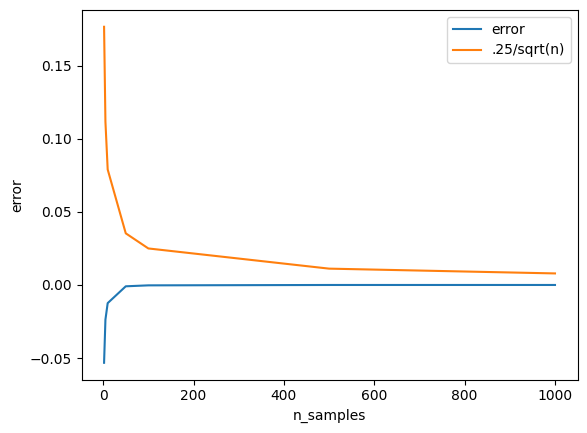

In [80]:
import matplotlib.pyplot as plt
revs = np.array(revs)
# for each sample size, we calculate the average error, compared to the
# optimal revenue, we calculate a few cells above.
error = np.mean(opt_rev - revs, axis=1)
# we plot the error as a function of the historical sample size
plt.plot(ngrid, error, label='error')
# should roughly behave as c/sqrt(n)
plt.plot(ngrid, .25/np.sqrt(ngrid), label='.25/sqrt(n)')
plt.xlabel('n_samples')
plt.ylabel('error')
plt.legend()
plt.show()

**Expected Answer**

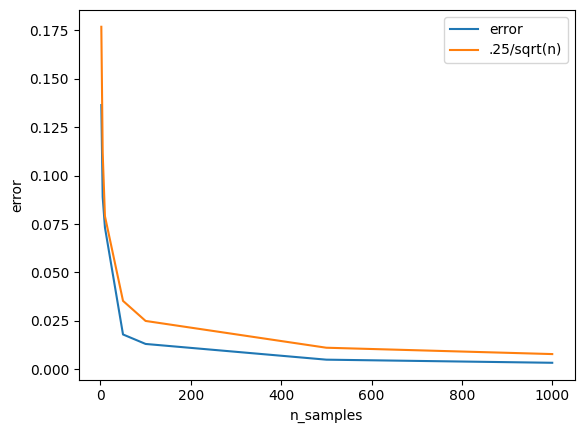

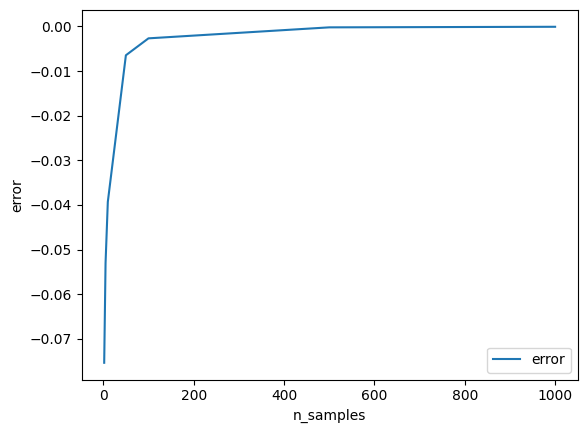

In [81]:
import matplotlib.pyplot as plt
# equivalently sqrt(m) * error, should be roughly converging to a constant
plt.plot(ngrid, np.sqrt(ngrid) * error, label='error')
plt.xlabel('n_samples')
plt.ylabel('error')
plt.legend()
plt.show()

**Expected Answer**

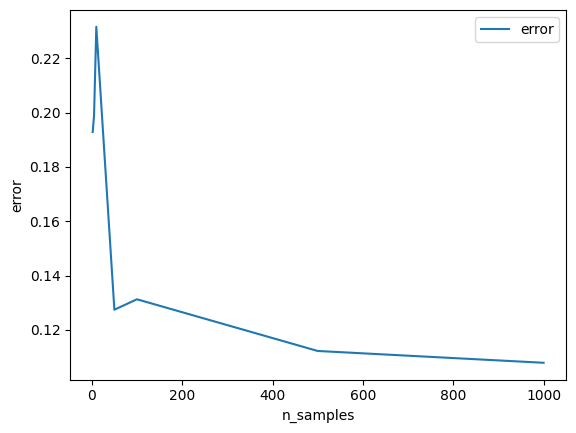

# Bonus Problem: Empirical Myerson Auction

**This problem will not be graded, and wont contribute to your grade, but if you want to dive deeper into Mechanism Design from Samples it is a great exercise. Feel free to submit it with your homework**

Implement the empirical Myerson auction described in Section 6.1 of this paper
https://theory.stanford.edu/~tim/papers/emp.pdf

This is an alternative to the ERM approach over discretize virtual value functions that is more computationally efficient.

You can remove if you want the "discarding" of the top fraction of bids (i.e. step 2) from your implementation.


In [ ]:
# Draw historical samples on which to train your empirical Myerson auction
np.random.seed(123)
v1, v2 = gen_data(1000)

In [ ]:
import scipy.spatial

def empirical_phi(v, rq):
    {{FILL IN}}

# This function should be taking the samples of a bidder
# and calculate the empirical virtual value function.
# In the end it should return a "function", which whenever given a new
# value v, it should return phi(v), where phi(.) is the empirical
# virtual function.
def empirical_virtual_value(values):
    {{FILL IN}}
    return lambda v: empirical_phi(v, rq)

In [ ]:
phi1 = empirical_virtual_value(v1)
phi2 = empirical_virtual_value(v2)

In [ ]:
import matplotlib.pyplot as plt
vgrid = np.linspace(.1, A-.1, 100)
plt.plot(vgrid, [phi1(v) for v in vgrid], label='est_phi')
plt.plot(vgrid, 2*vgrid - A, label='true_phi')
plt.legend()
plt.show()

**Expected Answer**

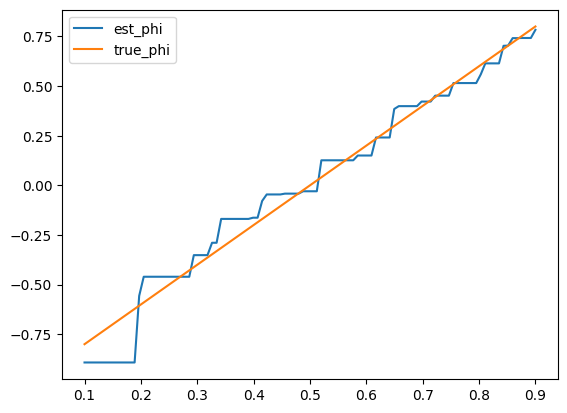

In [ ]:
vgrid = np.linspace(0.1, B - .1, 100)
plt.plot(vgrid, [phi2(v) for v in vgrid], label='est_phi')
plt.plot(vgrid, 2*vgrid - B, label='true_phi')
plt.legend()
plt.show()

**Expected Answer**

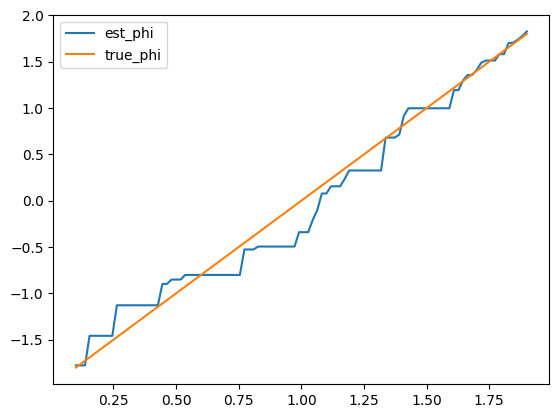

In [ ]:
# We now calculate for each bidder the "threshold function", i.e.
# for each value of opponent, what is the minimum value of the bidder to win
v1grid = np.linspace(0.001, A-0.001, 1000)
phi1v1grid = np.array([phi1(v1) for v1 in v1grid])
def threshold1(v2):
    phi2v2 = phi2(v2)
    return v1grid[np.clip(np.searchsorted(phi1v1grid, phi2v2), 0, len(v1grid)-1)]

v2grid = np.linspace(0.001, B-0.001, 1000)
phi2v2grid = np.array([phi2(v2) for v2 in v2grid])
def threshold2(v1):
    phi1v1 = phi1(v1)
    return v2grid[np.clip(np.searchsorted(phi2v2grid, phi1v1), 0, len(v2grid)-1)]

In [ ]:
plt.plot(vgrid, [threshold1(v) for v in vgrid], label='thr1v2')
plt.plot(vgrid, vgrid - (B-A)/2, label='true_thr1v2')
plt.plot(vgrid, [threshold2(v) for v in vgrid], label='thr2v1')
plt.plot(vgrid, vgrid + (B-A)/2, label='true_thr2v1')
plt.legend()
plt.show()

**Expected Answer**

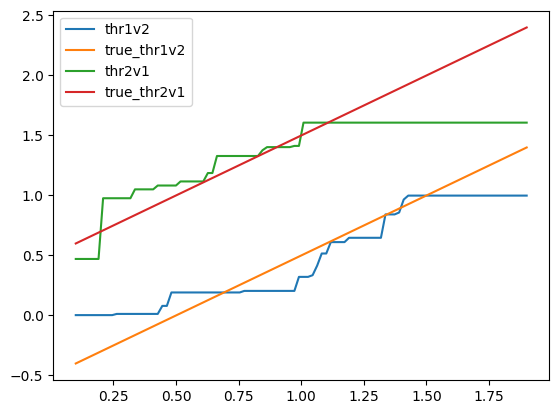

**Alternate Expected Answer** If you used value as virtual value for samples above the maximum observed sample:

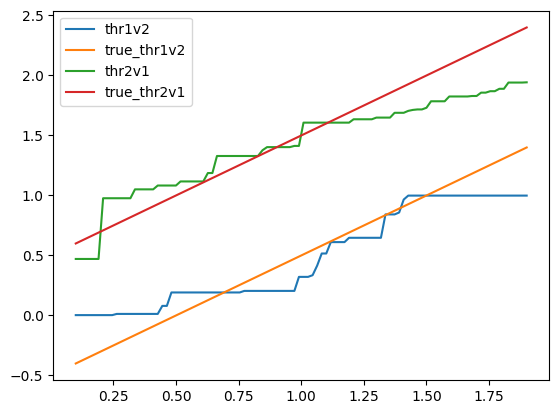

In [ ]:
# We also calculate the empirical monopoly reserves
v1grid = np.linspace(0.001, A, 1000)
v2grid = np.linspace(0.001, B, 1000)
eta1 = v1grid[np.searchsorted([phi1(v) for v in v1grid], 0)]
eta2 = v2grid[np.searchsorted([phi2(v) for v in v2grid], 0)]
eta1, eta2

**Expected Answer**

```
(0.517, 1.0835415415415415)
```

### Evaluate revenue of Empirical Myerson Auction on next year's data

In [ ]:
np.random.seed(1234)
v1, v2 = gen_data(100000)
phi1v1 = np.array([phi1(v) for v in v1])
phi2v2 = np.array([phi2(v) for v in v2])
thr2v1 = np.array([threshold2(v) for v in v1])
thr1v2 = np.array([threshold1(v) for v in v2])

In [ ]:
rev = 1.0 * ((phi1v1 < 0) & (phi2v2 >= 0)) * eta2
rev += 1.0 * ((phi1v1 >= 0) & (phi2v2 < 0)) * eta1
rev += 1.0 * ((phi1v1 >= 0) & (phi2v2 >= phi1v1)) * thr2v1
rev += 1.0 * ((phi1v1 > phi2v2) & (phi2v2 >= 0)) * thr1v2

In [ ]:
np.mean(rev)

**Expected Answer**

```
0.641780362112112
```